In [1]:
pip install ipyplot

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://imaxt.ast.cam.ac.uk/pip/
Note: you may need to restart the kernel to use updated packages.


In [2]:
from skimage.transform import pyramid_gaussian
from skimage import data
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, binary_opening, remove_small_holes, binary_erosion, binary_dilation
from skimage import measure
from skimage import data
from skimage.morphology import skeletonize, disk, ball
from skimage.filters import threshold_local, threshold_sauvola, threshold_niblack, threshold_otsu, rank

from scipy import ndimage
from scipy import stats
import os
import numpy as np
import sys
import statistics
from scipy import ndimage
import math
import SimpleITK as sitk
import gc
from PIL import Image

In [3]:

def GetTissue(volume, threshold = 6, alpha = 1, alpha_1d = 1, keep_largest = False, min_size_tissue = 100, min_size_holes = 100):
    
    print(file_name)
    print(output_file_name)
    print(threshold)
    print(alpha)
    print(alpha_1d)
    print(keep_largest)
    print(min_size_tissue)
    print(min_size_holes)
    
    
    
    #volume_itk = sitk.ReadImage(file_name, imageIO="MetaImageIO")

    #volume = sitk.GetArrayFromImage(volume_itk)

    tissue = volume > threshold
    tissue = tissue.astype(np.float)

    if alpha > 0:
        for i in range(0, tissue.shape[0]):
            #print("{}/{}".format(i, tissue.shape[0]))
            tissue[i,:,:] = ndimage.gaussian_filter(tissue[i,:,:], alpha)

    if alpha_1d > 0:
        tissue = ndimage.gaussian_filter1d(tissue, alpha_1d, 0)

    tissue = tissue > 0.5

    if min_size_tissue > 1:
        tissue = remove_small_objects(tissue, min_size_tissue)
    if min_size_holes > 1:
        tissue = remove_small_holes(tissue, min_size_holes)

    if keep_largest:
        labels = label(tissue)
        assert( labels.max() != 0 ) # assume at least 1 CC
        tissue = labels == np.argmax(np.bincount(labels.flat)[1:])+1

    tissue = tissue.astype(np.uint8)

    #tissue_itk = sitk.GetImageFromArray(tissue)
    #tissue_itk.SetSpacing(volume_itk.GetSpacing())
    #sitk.WriteImage(tissue_itk, output_file_name)
    print("done")
    return tissue



volumes/20190911_PDX_STG316_gfp_100x15um.mha
processed/20190911_PDX_STG316_gfp_100x15um.mha
6
1
1
False
100
100
done
volumes/20190911_PDX_STG316_gfp_100x15um.mha
processed/20190911_PDX_STG316_gfp_100x15um.mha
0.2
1
1
True
1
1
done


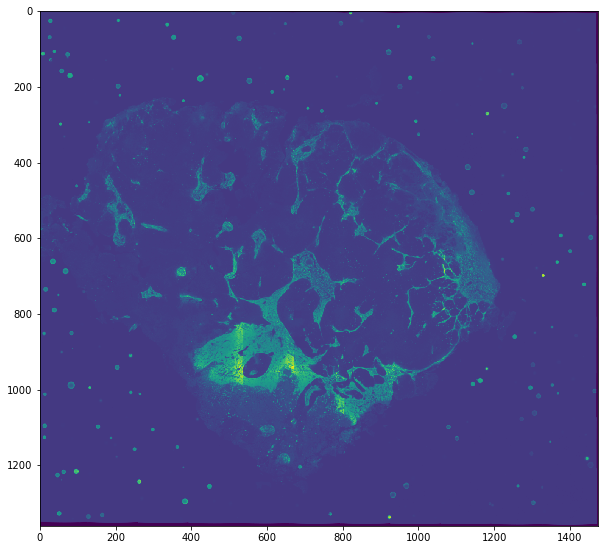

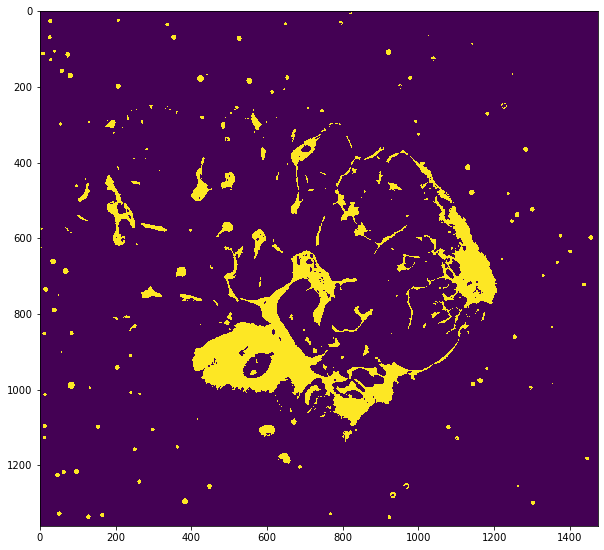

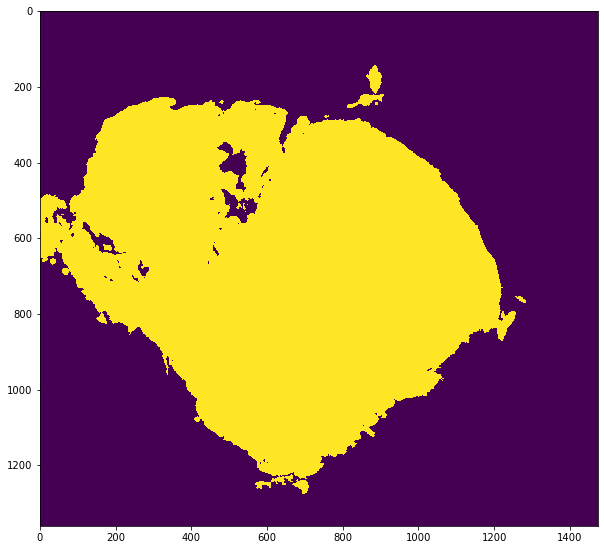

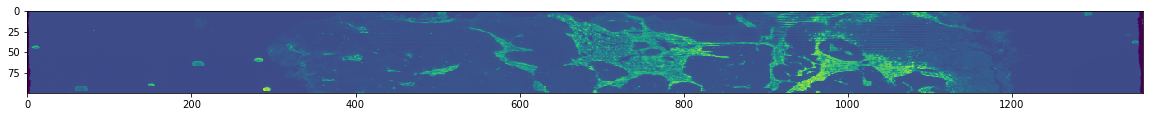

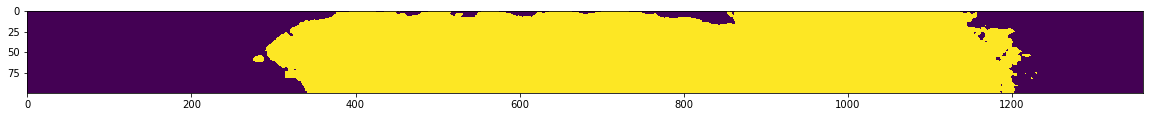

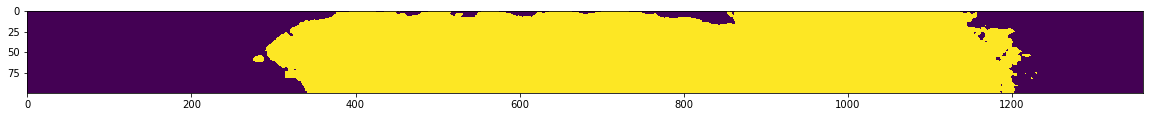

In [4]:

file_name = "volumes/20190911_PDX_STG316_gfp_100x15um.mha"
output_file_name = "processed/20190911_PDX_STG316_gfp_100x15um.mha"
volume_itk = sitk.ReadImage(file_name, imageIO="MetaImageIO")
volume = sitk.GetArrayFromImage(volume_itk)

threshold = 6
alpha = 1
alpha_1d = 1
keep_largest = False
min_size_tissue = 100
min_size_holes = 100

stroma = GetTissue(volume, threshold, alpha, alpha_1d, keep_largest, min_size_tissue, min_size_holes)

threshold = 0.2
alpha = 1
alpha_1d = 1
keep_largest = True
min_size_tissue = 1
min_size_holes = 1

tissue = GetTissue(volume, threshold, alpha, alpha_1d, keep_largest, min_size_tissue, min_size_holes)

from matplotlib import pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10) # (w, h)
plt.imshow(volume[int(volume.shape[0]/2)], interpolation='nearest')
plt.show()
plt.imshow(stroma[int(stroma.shape[0]/2)], interpolation='nearest')
plt.show()
plt.imshow(tissue[int(tissue.shape[0]/2)], interpolation='nearest')
plt.show()
plt.rcParams["figure.figsize"] = (20, 20) # (w, h)
plt.imshow(volume[:,:,int(volume.shape[2]/2)], interpolation='nearest')
plt.show()
plt.imshow(tissue[:,:,int(stroma.shape[2]/2)], interpolation='nearest')
plt.show()
plt.imshow(tissue[:,:,int(tissue.shape[2]/2)], interpolation='nearest')
plt.show()

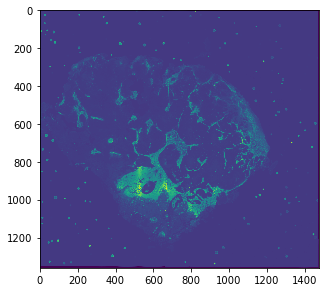

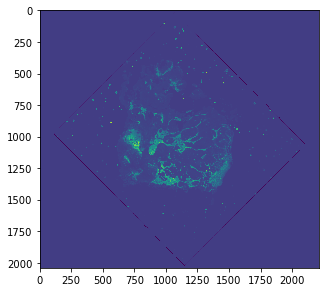

In [5]:
volume_itk = sitk.ReadImage(file_name, imageIO="MetaImageIO")
volume = sitk.GetArrayFromImage(volume_itk)

transform = sitk.Euler3DTransform()
rotate = -45
rotation = rotate * 3.14159265359/180
transform.SetIdentity()
transform.SetCenter([int(volume_itk.GetSpacing()[0]*volume_itk.GetSize()[0]/2), int(volume_itk.GetSpacing()[1]*volume_itk.GetSize()[1]/2), int(volume_itk.GetSpacing()[2]*volume_itk.GetSize()[2]/2)])
transform.SetRotation (0, 0, rotation)

resampler = sitk.ResampleImageFilter()
resampler.SetInterpolator(sitk.sitkLinear)

resampler.SetSize([int(volume_itk.GetSize()[0]*1.5),int(volume_itk.GetSize()[1]*1.5),volume_itk.GetSize()[2]])
resampler.SetOutputSpacing([volume_itk.GetSpacing()[0], volume_itk.GetSpacing()[0], volume_itk.GetSpacing()[0]])
resampler.SetOutputOrigin([int(0.25*volume_itk.GetSpacing()[0]*-volume_itk.GetSize()[0]), int(0.25*volume_itk.GetSpacing()[1]*-volume_itk.GetSize()[1]), 0])

resampler.SetOutputPixelType(sitk.sitkFloat32)
resampler.SetDefaultPixelValue(0)
resampler.SetTransform(transform)
volume2_itk = resampler.Execute(volume_itk)
volume2 = sitk.GetArrayFromImage(volume2_itk)

from matplotlib import pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5) # (w, h)
plt.imshow(volume[int(volume.shape[0]/2)], interpolation='nearest')
plt.show()
plt.imshow(volume2[int(volume2.shape[0]/2)], interpolation='nearest')
plt.show()


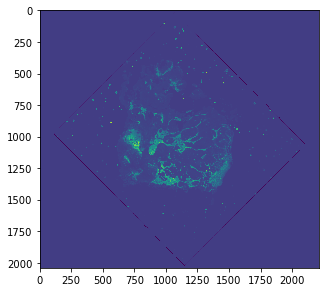

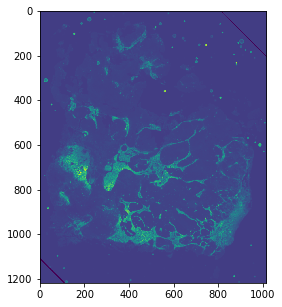

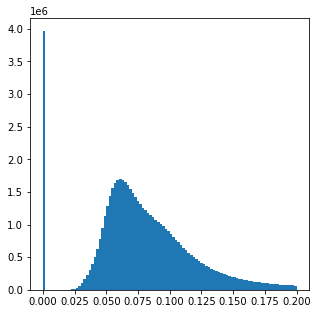

In [6]:

maxX_final = 0
minX_final = sys.maxsize
maxY_final = 0
minY_final = sys.maxsize
maxZ_final = 0
minZ_final = sys.maxsize

mask = volume2 > 0.2

labels = label(mask)
assert( labels.max() != 0 ) # assume at least 1 CC
mask = labels == np.argmax(np.bincount(labels.flat)[1:])+1


objs = ndimage.find_objects(mask)
#maxX = int(objs[0][0].stop)
#minX = int(objs[0][0].start)
maxY = int(objs[0][1].stop)
minY = int(objs[0][1].start)
maxZ = int(objs[0][2].stop)
minZ = int(objs[0][2].start)

#maxX_final = max(maxX_final, maxX)
#minX_final = min(minX_final, minX)
maxY_final = max(maxY_final, maxY)
minY_final = min(minY_final, minY)
maxZ_final = max(maxZ_final, maxZ)
minZ_final = min(minZ_final, minZ)

minX_final = 0
maxX_final = volume2.shape[0]

#volume3 = np.zeros(volume2.shape)
volume3 = volume2[:,minY_final:maxY_final, minZ_final:maxZ_final]

#volume3 = np.pad(volume3, ((0, 0), (200, 0), (0, 200)))


plt.imshow(volume2[int(volume2.shape[0]/2)], interpolation='nearest')
plt.show()
plt.imshow(volume3[int(volume3.shape[0]/2)], interpolation='nearest')
plt.show()

plt.hist(volume3.flatten(), bins = 100, range=[0,0.2])
plt.show()


volumes/20190911_PDX_STG316_gfp_100x15um.mha
processed/20190911_PDX_STG316_gfp_100x15um.mha
6
1
1
False
100
100
done
volumes/20190911_PDX_STG316_gfp_100x15um.mha
processed/20190911_PDX_STG316_gfp_100x15um.mha
0.2
1
1
True
1
1
done


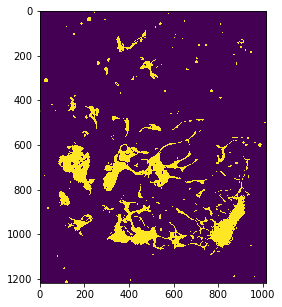

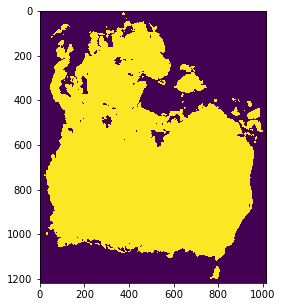

In [7]:
threshold = 6
alpha = 1
alpha_1d = 1
keep_largest = False
min_size_tissue = 100
min_size_holes = 100

stroma = GetTissue(volume3, threshold, alpha, alpha_1d, keep_largest, min_size_tissue, min_size_holes)

threshold = 0.2
alpha = 1
alpha_1d = 1
keep_largest = True
min_size_tissue = 1
min_size_holes = 1

tissue = GetTissue(volume3, threshold, alpha, alpha_1d, keep_largest, min_size_tissue, min_size_holes)

from matplotlib import pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5) # (w, h)
plt.imshow(stroma[int(stroma.shape[0]/2)], interpolation='nearest')
plt.show()
plt.imshow(tissue[int(tissue.shape[0]/2)], interpolation='nearest')
plt.show()

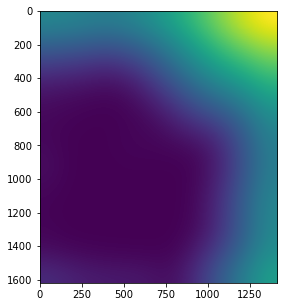

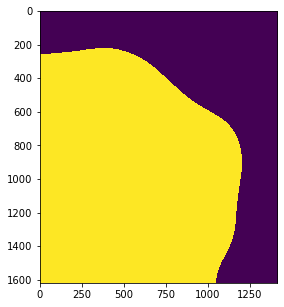

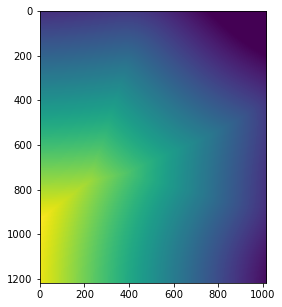

In [8]:
from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage import gaussian_filter
#tissue = volume3 < 0.2
#plt.imshow(tissue[int(tissue.shape[0]/2)], interpolation='nearest')
#plt.show()


tissue2 = np.zeros([tissue.shape[0], tissue.shape[1]+400, tissue.shape[2]+400])
tissue2[:, 400:tissue.shape[1]+400, :tissue.shape[2]] = tissue

distance_map = distance_transform_edt(1-tissue2)

distance_map = gaussian_filter(distance_map, sigma=100)

plt.imshow(distance_map[int(distance_map.shape[0]/2)], interpolation='nearest')
plt.show()

distance_map = distance_map < 200
plt.imshow(distance_map[int(distance_map.shape[0]/2)], interpolation='nearest')
plt.show()

distance_map = distance_transform_edt(distance_map)
distance_map = distance_map[:, 400:distance_map.shape[1], :tissue.shape[2]]

from matplotlib import pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5) # (w, h)
plt.imshow(distance_map[int(distance_map.shape[0]/2)], interpolation='nearest')
plt.show()




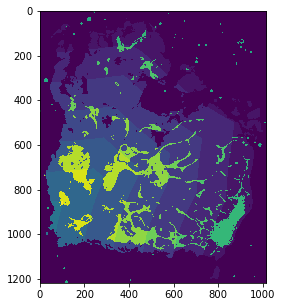

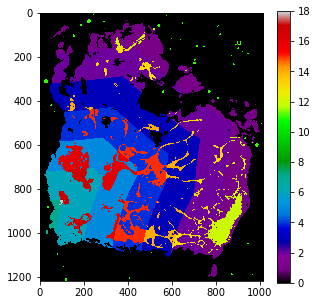

In [9]:
distance_map2 = np.zeros(distance_map.shape)
nr_of_regions = 10

for i in range(0, nr_of_regions):
    f_min = 200 + 133 * i;
    f_max = 200 + 133 * (i+1);
    
    distance_map2[(distance_map < f_max) & (distance_map >= f_min)] = i+1
    
#distance_map2[(distance_map < 250) & (distance_map >= 200)] = 1
#distance_map2[(distance_map < 300) & (distance_map >= 250)] = 2
#distance_map2[(distance_map < 350) & (distance_map >= 300)] = 3
#distance_map2[(distance_map < 400) & (distance_map >= 350)] = 4
#distance_map2[(distance_map < 450) & (distance_map >= 400)] = 5
#distance_map2[(distance_map < 500) & (distance_map >= 450)] = 6
#distance_map2[(distance_map < 550) & (distance_map >= 500)] = 7
#distance_map2[(distance_map < 600) & (distance_map >= 550)] = 8
#distance_map2[(distance_map < 650) & (distance_map >= 600)] = 9

distance_map2[tissue != 1] = 0
distance_map2[stroma == 1] += nr_of_regions+1
distance_map2 = distance_map2[:,:,:distance_map2.shape[2]]



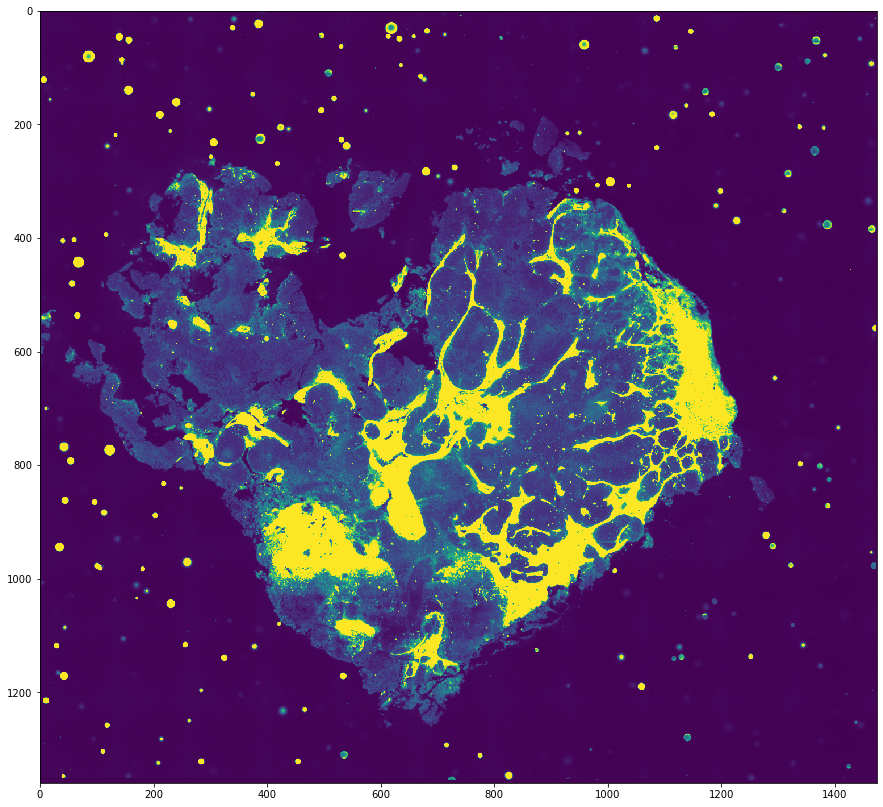

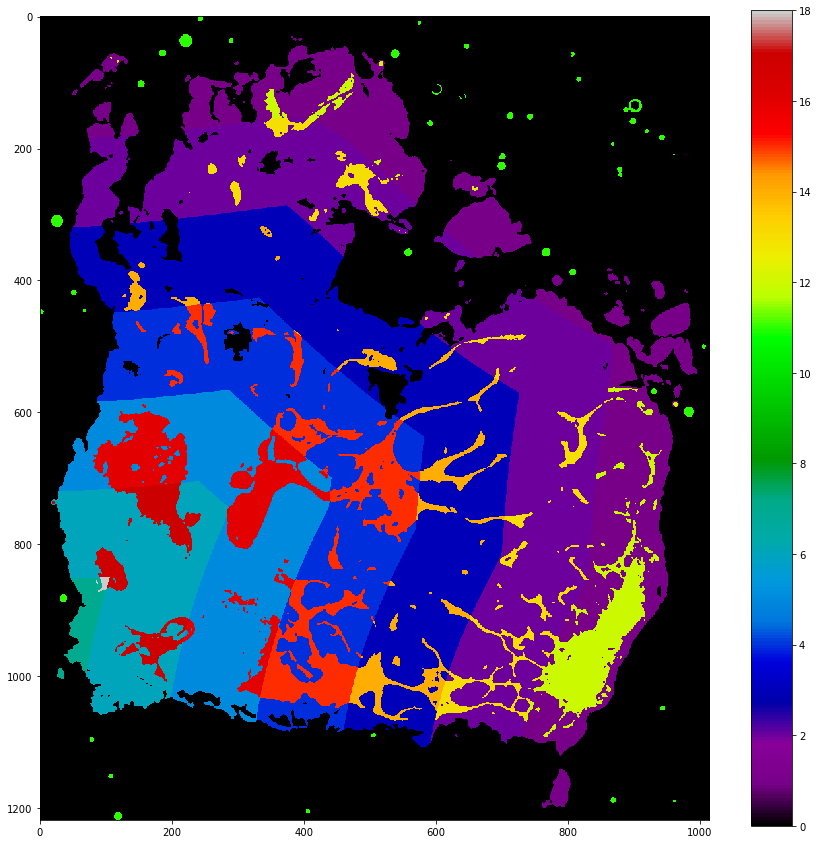

In [14]:

plt.rcParams["figure.figsize"] = (15, 15) # (w, h)
plt.imshow(np.clip(volume[int(volume.shape[0]/4)], 0, 6), interpolation='nearest')
plt.show()
plt.imshow(distance_map2[int(volume.shape[0]/2)], interpolation='nearest', cmap=plt.get_cmap("nipy_spectral"))
plt.colorbar();
plt.savefig('regions.jpg')
plt.show()